In [18]:
%matplotlib widget

In [19]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

In [20]:
env = xt.Environment()
env.call('../fccee_z_lattice.py')
env.call('../002_design_optics/quad_strength_limits.py')

env.call('../002_design_optics/matching_constraints.py')

In [21]:
line = env['cell_uffl']

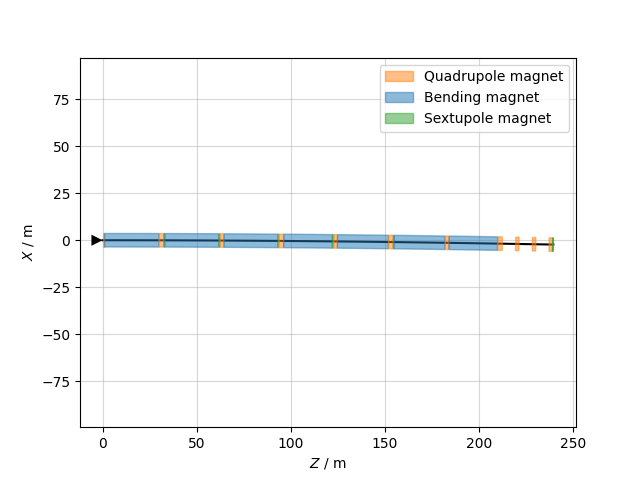

In [22]:
line.survey().plot()

In [23]:
# To ge boundary conditions on the arc side we load the arc cell strengths from previous match
env.vars.load_json('strengths_quads_00_arc_cell.json')
tw_uu = (2 * env['cell_u']).twiss4d()

### Strengths to match

In [24]:
kq_ff_ds = [
    'kqfm0l', 'kqdm0l', 'kqfm1l', 'kqdm2l', 'kqfm3l',
    'kqdm4l', 'kqfm5l', 'kqdm6l', 'kqfm7l', 'kqdm8l',
]

In [25]:
# Initialize quadrupoles with a small strength
for nn in kq_ff_ds:
    if line.vars.vary_default[nn]['limits'][1] > 1e-3: # Focusing quad
        line[nn] = 1e-3
    else: # Defocusing quad
        line[nn] = -1e-3

In [26]:
opt = line.match(
    solve=False,
    method='4d',
    betx=tw_uu.betx[0], bety=tw_uu.bety[0],
    alfx=tw_uu.alfx[0], alfy=tw_uu.alfy[0],
    dx=tw_uu.dx[0], dpx=tw_uu.dpx[0],
    vary=xt.VaryList(kq_ff_ds, step=1e-10),
    targets=[
        xt.TargetSet(at=xt.END,
            betx=env['bx_ff_out'],
            bety=env['by_ff_out'],
            alfx=0, alfy=0, dx=0, dpx=0,
            mux = tw_uu.mux[-1]  * 0.25 + 0.50,
            muy = tw_uu.muy[-1]  * 0.25 + 0.50),
        xt.TargetSet(dx=0, dpx=0, at='qdm6l', weight=1000),
        xt.TargetSet(dx=0, dpx=0, at='qfm5l', weight=1000),
        xt.TargetSet(bety=xt.GreaterThan(350), at='qfm5l'),
        xt.TargetSet(bety=xt.GreaterThan(600), at='qfm7l'),
        xt.TargetSet(bety=xt.LessThan(600), at='qdm6l'),
        xt.TargetSet(betx=xt.LessThan(200), bety=xt.LessThan(200), at='qfm0l'),
        xt.TargetSet(betx=xt.LessThan(200), bety=xt.LessThan(200), at='qfm1l'),
        xt.TargetSet(betx=xt.LessThan(200), bety=xt.LessThan(200), at='qdm2l'),
        xt.TargetSet(betx=xt.LessThan(200), bety=xt.LessThan(200), at='qfm3l'),
        xt.TargetSet(betx=xt.LessThan(200), bety=xt.LessThan(200), at='qdm4l'),
    ],
)

In [27]:
opt.targets['END_mux'].weight = 1000
opt.targets['END_muy'].weight = 1000

In [28]:
opt.run_jacobian(50)
opt.run_nelder_mead(1000)
opt.run_jacobian(50)

                                             
Optimize - start penalty: 4648                              
Matching: model call n. 719 penalty = 3.2988e+02              
Optimize - end penalty:  329.881                            
                                             
Optimize - start penalty: 329.9                               
Matching: model call n. 2131 penalty = 5.9316e+01              
Optimize - end penalty:  59.3156                            
                                             
Optimize - start penalty: 59.32                                
Matching: model call n. 2403 penalty = 8.4412e-12              
Optimize - end penalty:  8.44116e-12                            
                                             
Optimize - start penalty: 8.441e-12                            
Matching: model call n. 3451 penalty = 8.4412e-12              
Optimize - end penalty:  8.44116e-12                            


In [12]:
opt.target_mismatch()

Target mismatch:             enalty = 3.2988e+02              
id state tag        tol_met       residue   current_val target_val         description                                 
0  ON    END_betx     False      -56.8869       9.78008 66.667             line=cell_uffl, ('betx', '_end_point'),  ...
1  ON    END_bety     False      -227.213       1372.79 1600.0             line=cell_uffl, ('bety', '_end_point'),  ...
2  ON    END_alfx     False      0.703542      0.703542 0                  line=cell_uffl, ('alfx', '_end_point'),  ...
3  ON    END_alfy     False      -2.38636      -2.38636 0                  line=cell_uffl, ('alfy', '_end_point'),  ...
4  ON    END_mux      False     0.0471783      0.900304 0.8531254327772382 line=cell_uffl, ('mux', '_end_point'), v ...
5  ON    END_muy      False     -0.189703      0.619002 0.808704987948256  line=cell_uffl, ('muy', '_end_point'), v ...
6  ON    END_dx       False      0.189643      0.189643 0                  line=cell_uffl, ('dx',

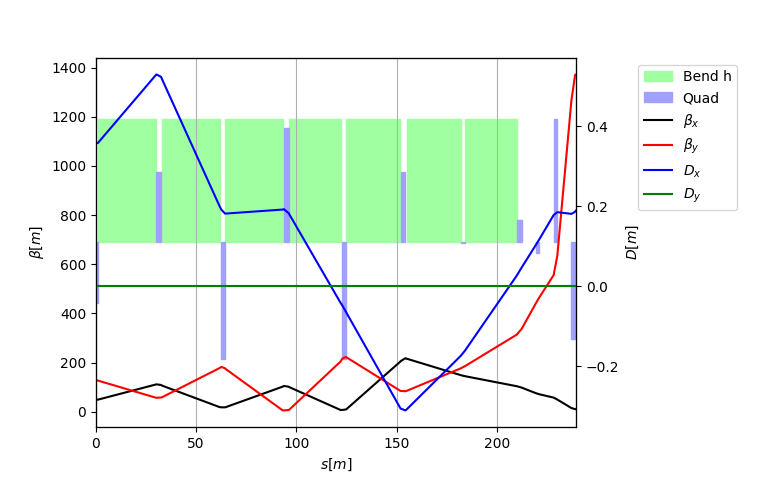

In [13]:
opt.plot()

In [14]:
# Other side from the ip is symmetric
kq_right = ['kqfm0r', 'kqdm0r', 'kqfm1r', 'kqdm2r', 'kqfm3r',
            'kqdm4r', 'kqfm5r', 'kqdm6r', 'kqfm7r', 'kqdm8r']

env['kqfm0r'] = 'kqfm0l'
env['kqdm0r'] = 'kqdm0l'
env['kqfm1r'] = 'kqfm1l'
env['kqdm2r'] = 'kqdm2l'
env['kqfm3r'] = 'kqfm3l'
env['kqdm4r'] = 'kqdm4l'
env['kqfm5r'] = 'kqfm5l'
env['kqdm6r'] = 'kqdm6l'
env['kqfm7r'] = 'kqfm7l'
env['kqdm8r'] = 'kqdm8l'

In [39]:
strengths = line.vars.get_table().rows[kq_ff_ds + kq_right]
strengths = strengths.to_dict()

In [40]:
xt.json.dump(strengths, 'strengths_quads_05_ffds_lr.json')